In [2]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
data_path = r'C:\Users\UAB\data\NII_Binarized'
images = []
segmentations = []
for f in os.listdir(data_path):
  if '_K' in f:
    continue
  else:
    images.append(f)
    segmentations.append(f.replace('.nii', '_K.nii'))

print(images[0], segmentations[0])
images = np.array(images)
segmentations = np.array(segmentations)

indices = np.array(range(len(images))) # we will use this in the next step.


101934_1_96_L_M.nii 101934_1_96_L_M_K.nii


In [5]:
print(len(images))

246


In [6]:
images = np.array(images[0:80])
segmentations = np.array(segmentations[0:80])
indices = np.array(range(len(images)))

In [7]:
print(len(images))

80


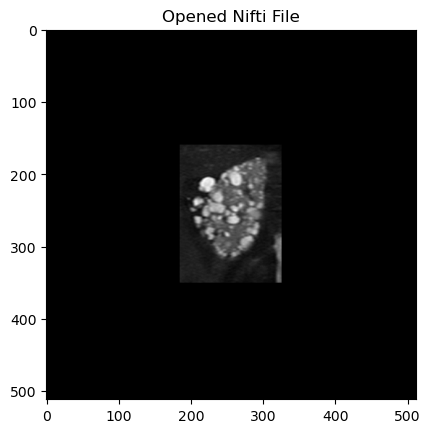

In [8]:
train, test = train_test_split(indices, test_size=0.25) # TODO: split indices into training and test partitions
path = (data_path+'\\'+images[train][0])
nifti_image = nib.load(path)
nifti_data = nifti_image.get_fdata()
nifti_slice = nifti_data[:,:,50]
plt.imshow(nifti_slice, cmap='gray')
plt.title('Opened Nifti File')
plt.show()

In [9]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')
    
def retrieve_images_and_segmentations(data_path, images, segmentations, size=(512,512)):
  x = []
  y = []
  for i in range(len(images)):
    seg = read_nifti_file(data_path+segmentations[i])
    img = read_nifti_file(data_path+images[i])
    assert img.shape == seg.shape
    seg = resize(seg,(size[0], size[1], seg.shape[-1]))
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(seg.shape[-1]):
      # ignore slices that don't have a segmentation
      if np.sum(seg[:,:,j]) == 0:
        continue
      x.append(img[:,:,j])
      y.append(seg[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]
  y = np.array(y)[:,:,:,np.newaxis]

  # randomly shuffle slices
  m = x.shape[0]
  order = np.random.permutation(m)

  return x[order], y[order]

def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

In [10]:
train, valid = train_test_split(train, test_size=0.25)
example_image = read_nifti_file(data_path+'\\'+images[train][0]) # TODO: read in the first image from the training partition
example_segmentation = read_nifti_file(data_path+'\\'+segmentations[train][0])  # TODO: read in the first segmentation from the training partition

print(example_image.shape, example_segmentation.shape)

(512, 512, 96) (512, 512, 96)


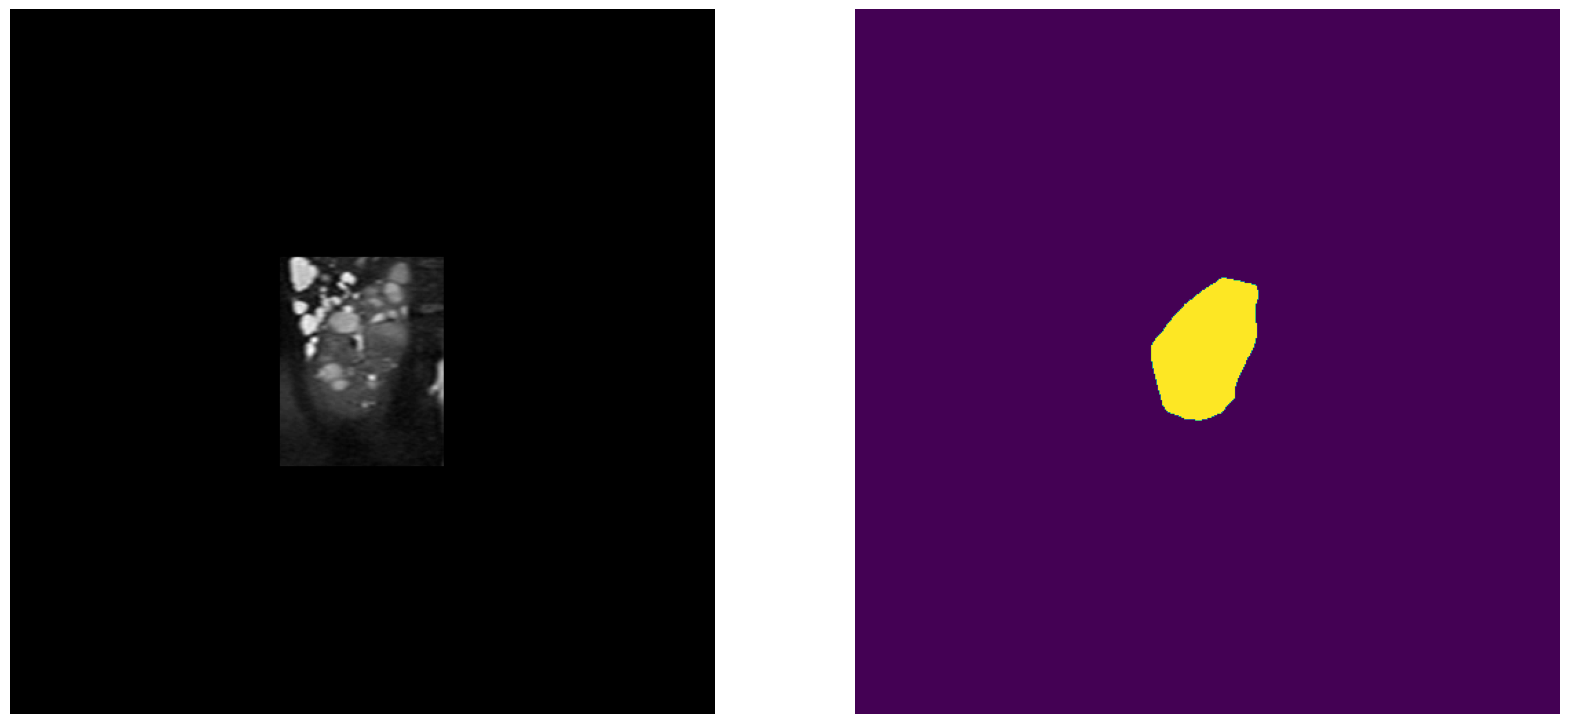

In [11]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(example_image[:,:,40], cmap='gray') # TODO: display the first slice from the image
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(example_segmentation[:,:,40])  # TODO: display the first slice from the segmentation
ax2.axis('off')
plt.show()

In [13]:
data_path = r'C:\Users\UAB\data\NII_Binarized\\'
x_train, y_train = retrieve_images_and_segmentations(data_path, images[train], segmentations[train]) #TODO: get the matrices for the training partition
print(x_train.shape, y_train.shape)

(3159, 512, 512, 1) (3159, 512, 512, 1)


In [14]:
x_valid, y_valid = retrieve_images_and_segmentations(data_path, images[valid], segmentations[valid]) #TODO: get the matrices for the validation partition
print(x_valid.shape, y_valid.shape)

(1073, 512, 512, 1) (1073, 512, 512, 1)


In [15]:
x_test, y_test = retrieve_images_and_segmentations(data_path, images[test], segmentations[test]) #TODO: get the matrices for the test partition
print(x_test.shape, y_test.shape)

(1429, 512, 512, 1) (1429, 512, 512, 1)


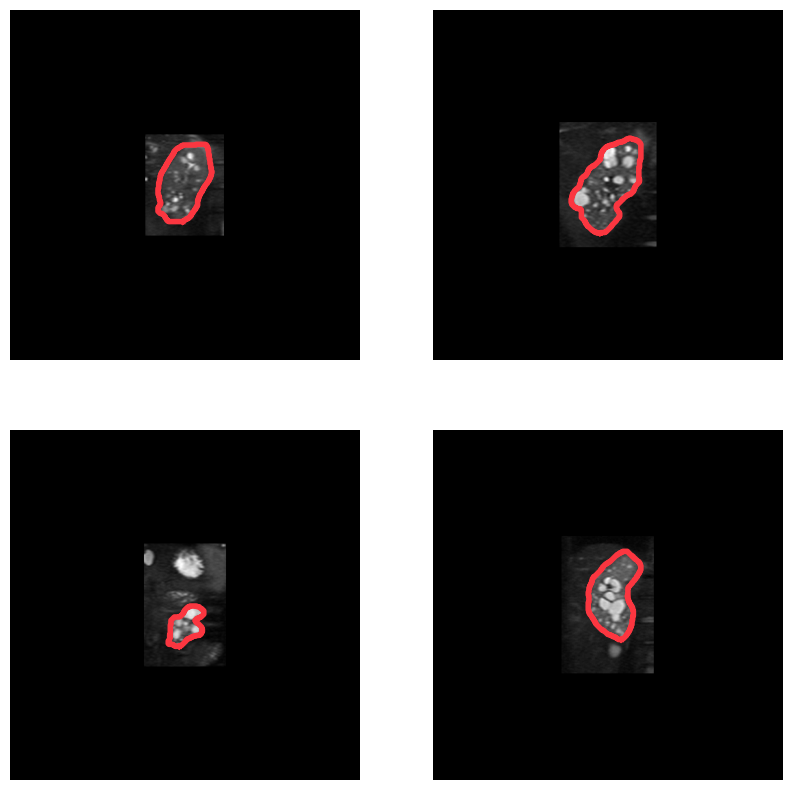

In [16]:
visualise_data(x_train, y_train)
plt.show()

In [17]:
model = custom_unet(input_shape=(512, 512, 1))

In [18]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "10epoch_binaryMask.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

In [20]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=10)

Epoch 1/10
99/99 [==============================] - 50s 398ms/step - loss: 0.3465 - dice_coef: 0.1144 - val_loss: 0.1283 - val_dice_coef: 0.2538
Epoch 2/10
99/99 [==============================] - 35s 352ms/step - loss: 0.2050 - dice_coef: 0.1762 - val_loss: 0.0908 - val_dice_coef: 0.3246
Epoch 3/10
99/99 [==============================] - 35s 354ms/step - loss: 0.1674 - dice_coef: 0.2076 - val_loss: 0.0877 - val_dice_coef: 0.3323
Epoch 4/10
99/99 [==============================] - 35s 355ms/step - loss: 0.1417 - dice_coef: 0.2359 - val_loss: 0.0869 - val_dice_coef: 0.3343
Epoch 5/10
99/99 [==============================] - 35s 355ms/step - loss: 0.1238 - dice_coef: 0.2611 - val_loss: 0.0844 - val_dice_coef: 0.3408
Epoch 6/10
99/99 [==============================] - 35s 356ms/step - loss: 0.1101 - dice_coef: 0.2840 - val_loss: 0.0843 - val_dice_coef: 0.3412
Epoch 7/10
99/99 [==============================] - 35s 356ms/step - loss: 0.0916 - dice_coef: 0.3210 - val_loss: 0.0407 - val_dic

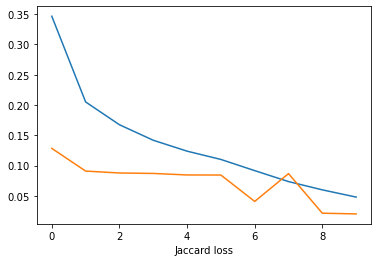

In [21]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

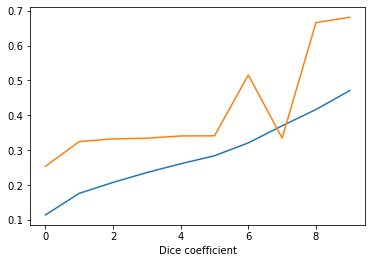

In [22]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [23]:
from keras.models import Sequential, load_model
model.save('10epoch_binaryMask.h5')

In [25]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('10epoch_binaryMask.h5')

In [26]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [27]:
y_pred_train = model.predict(x_train) #TODO: predict on the training set
y_pred_train = y_pred_train.astype('float') 

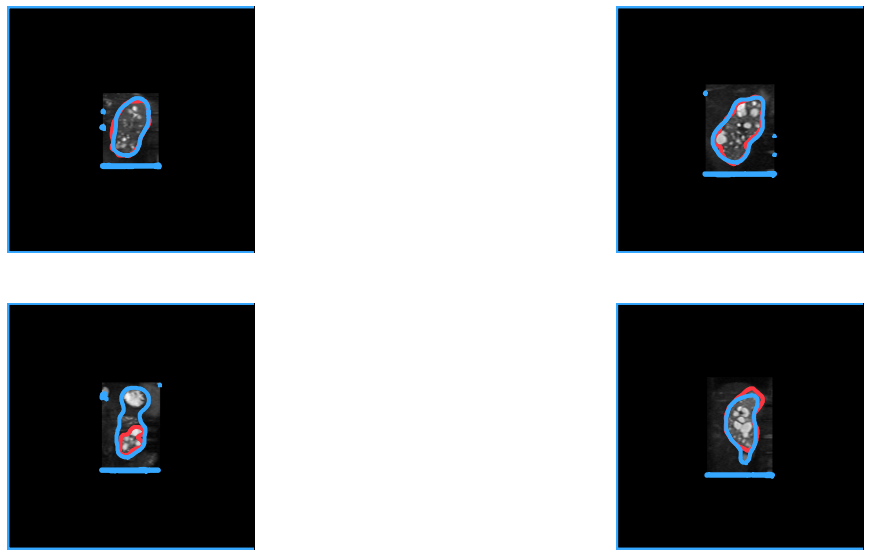

In [28]:
visualise_data_and_prediction(x_train, y_train, y_pred_train)

In [30]:
y_pred_valid = model.predict(x_valid) #TODO: predict on the validation set
y_pred_valid = y_pred_valid.astype('float') # casting to type float to avoid ValueError later
#print('Dice:')
#print(np.array(dice_coef(y_valid, y_pred_valid.astype('float'))))

In [34]:
def retrieve_images_for_prediction(data_path, images,num, size=(512,512)):
  x = []
  for i in range(num):
    img = read_nifti_file(data_path+'\\'+images[i])
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(img.shape[-1]):
      x.append(img[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]

  return x


In [35]:
prediction_set = retrieve_images_for_prediction(data_path, images, 5, size=(512,512))

In [36]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('10epoch_binaryMask.h5')

In [37]:
MR_K_predictions = model.predict(prediction_set)
MR_K_predictions = MR_K_predictions.astype('float')

In [40]:
orig_filename = images[1]
orig_clip_fname = orig_filename[:-4]
print(orig_clip_fname)

new_fname = '%s_PREDICTION_10_epoch.nii' %orig_clip_fname
print(new_fname)

final_path = r'C:\Users\UAB\data\NII_Binarized\Predictions saved'
affine = np.eye(4)
new_set = np.zeros((512,512,96))
test_data = MR_K_predictions[0:96,:,:,0]
for i in range(test_data.shape[0]):
    new_set[:,:,i] = test_data[i,:,:]

nifti_file = nib.Nifti1Image(new_set, affine)
nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))

101934_1_96_R_M
101934_1_96_R_M_PREDICTION_10_epoch.nii


In [ ]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "10epoch_binaryMask.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

In [ ]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=50)